# Вправа 2

Одним з недоліків дерев прийняття рішень є їхня варіативність: при найменшій зміні навчальних даних, побудоване дерево може виглядати абсолютно інакше. Відповідно важко зберігати стійкість моделі.

Ця проблема вирішується методами асамблювання (ensemble methods). Найчастіше використовуються беггінг (bagging) та бустінг (boosting).

Принцип роботи цих методів полягає у створенні не однієї моделі (одного дерева), а набору моделей.

Наприклад, ми створюємо модель з 100 дерев. При цьому, ми не хочемо мати 100 абсолютно одинакових дерев, навчивши їх на одних і тих же даних. Тому ми генеруємо з початкового навчального датасету 100 нових навчальних датасетів (для кожного дерева свій).

Основна різниця між методами беггінгу та бустингу полягає у тому, як генеруються датасети.

У випадку беггінгу, кожен запис з початкового навчального датасету має одинакову ймовірність потрапити в новий навчальний датасет. При бустингу, для кожного запису встановлюються певні ваги і певні дані мають більшу ймовірність потрапити в нові навчальні датасети ніж інші.

Зверніть увагу, що в обох методах немає заборони на входження певного запису у новий датасет більш ніж один раз, тобто дані в межах окремого нового датасету можуть повторюватись.

На практиці, при беггінгу всі дерева є незалежними між собою і можуть навчатись паралельно.

У бустингу ж при навчанні i-того дерева використовуються ваги з результатів попереднього дерева.

При цьому вага встановлюється більшою для тих даних, в яких навчене дерево зробило помилку. Таким чином підкреслюється, що це складніший випадок і його треба краще вивчити.

Як наслідок, навчання є послідовних і повільнішим.

![](bagging-vs-boosting.png)

За аналонічним принципом відбувається і визначення кінцевого результату складної моделі.

При беггінгу, кінцеве значення моделі є середнім між значеннями окремих дерев.

Бустинг ж також встановлює ваги кожному дереву на основі якості його передбачень.

## Підготовка до практики

Встановіть необхідні залежності

In [1]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/bc/43/242432efc3f60052a4a534dc4926b21e236ab4ec8d4920c593da3f65c65d/xgboost-2.0.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 653.6 kB/s eta 0:02:33
   ---------------------------------------- 0.3/99.8 MB 2.6 MB/s eta 0:00:39
   ---------------------------------------- 0.7/99.8 MB 5.3 MB/s eta 0:00:19
   ---------------------------------------- 1.1/99.8 MB 6.5 MB/s eta 0:00:16
    --------------------------------------- 1.6/99.8 MB 7.2 MB/s eta 0:00:14
    --------------------------------------- 2.1/99.8 MB 8.2 MB/s eta 0:00:12
   - -------------------------------------- 2.5/99.8 MB 8.5 MB/s eta 0:00:12
   - -------------------------------------- 3.0/99.8 MB 9.2 MB/s eta 0:00:11
   - --------------------------------

Проімпортуйте необхідні пакети

In [2]:
import numpy as np
np_seed = 42

import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from xgboost import XGBClassifier, XGBRegressor

# classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# regression metrics
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

## Обробка даних

В межах даної вправи ми використаємо датасет з навчальними успіхами з математики з двох навчальних закладів Португалії (Gabriel Pereira та Mousinho da Silveira). В Португалії діє 20-бальна система, [детальніше тут](https://en.wikipedia.org/wiki/Academic_grading_in_Portugal).

З датасету ми приберемо оцінки за модулі (колонки `G1` та `G2` та залишимо виключно кінцеву оцінку `G3`, перейменувавши її в `Grade`).

In [3]:
def load_students_data():
    data = pd.read_csv("student-mat.csv", sep=';')
    data.drop(columns = ['G1', 'G2'], inplace=True)
    data.rename(columns={'G3':'Grade'}, inplace=True)
    
    return data
    
student_data = load_students_data()
student_data.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,yes,no,5,4,2,1,2,5,10,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,yes,no,4,4,4,1,1,3,0,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,no,no,4,1,4,1,1,1,6,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,yes,no,4,2,2,1,1,1,0,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,yes,no,5,5,1,1,1,5,0,15


Інформація по даних в колонках:

- school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
- sex - student's sex (binary: "F" - female or "M" - male)
- age - student's age (numeric: from 15 to 22)
- address - student's home address type (binary: "U" - urban or "R" - rural)
- famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
- Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
- Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
- guardian - student's guardian (nominal: "mother", "father" or "other")
- traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- failures - number of past class failures (numeric: n if 1<=n<3, else 4)
- schoolsup - extra educational support (binary: yes or no)
- famsup - family educational support (binary: yes or no)
- paid - extra paid classes within the course subject (Math) (binary: yes or no)
- activities - extra-curricular activities (binary: yes or no)
- nursery - attended nursery school (binary: yes or no)
- higher - wants to take higher education (binary: yes or no)
- internet - Internet access at home (binary: yes or no)
- romantic - with a romantic relationship (binary: yes or no)
- famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- freetime - free time after school (numeric: from 1 - very low to 5 - very high)
- goout - going out with friends (numeric: from 1 - very low to 5 - very high)
- Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
- health - current health status (numeric: from 1 - very bad to 5 - very good)
- absences - number of school absences (numeric: from 0 to 93)

### <span style="color:red">Завдання 1</span>

<span style="color:red">**a)**</span> Побудуйте лінійний графік залежності середньої оцінки студентів від того, наскільки якісні стосунки в сім'ї (`famrel`).

C:\Users\Admin\AppData\Local\Temp\ipykernel_18736\2979388663.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(student_data.famrel, student_data.Grade, s=50, cmap='spring')


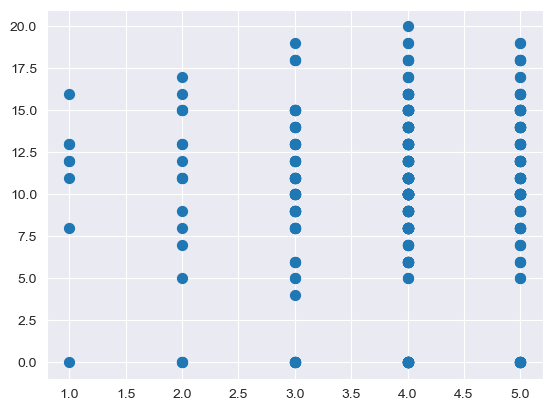

In [6]:
plt.scatter(student_data.famrel, student_data.Grade, s=50, cmap='spring')
plt.show()

<span style="color:red">**b)**</span> Побудуйте лінійний графік залежності середньої оцінки студентів від того, скільки часу вони приділяють навчанню (`studytime`).

<Axes: ylabel='studytime'>

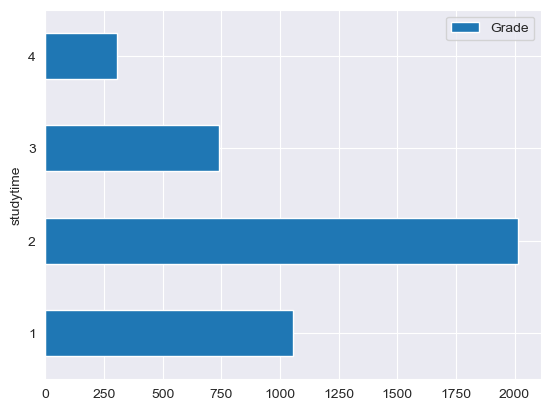

In [8]:
student_data[['Grade', "studytime"]].groupby('studytime').sum().plot.barh()

### <span style="color:red">Завдання 2</span>

В датасеті є ряд колонок, в яких значеннями можуть бути тільки слова `yes` та `no`. Проте, моделі машинного навчання вимагають від нас числових даних, тому у таких колонках замініть значення `yes` числом 1 та значення `no` числом 0.

<span style="color:red">**a)**</span> Створіть список колонок з значеннями 'yes-no'.

In [21]:
# Write column names into this array
yes_no_cols = list(filter(lambda x: student_data[x][student_data[x] == 'yes'].any() or student_data[x][student_data[x] == 'no'].any(), student_data.columns))

yes_no_cols

['schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

<span style="color:red">**b)**</span> Для колонок з `yes_no_cols` перетворіть відповідні колонки датафрейму на числові. Виведіть перші 5 записів датафрейму.

**Рекомендація**. Використайте функцію [`DataFrame.applymap`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.applymap.html).

In [35]:
student_data[yes_no_cols] = student_data[yes_no_cols].applymap(lambda val: int(val == 'yes'))

student_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Grade
0,GP,1,18,U,GT3,A,4,4,at_home,teacher,...,0,0,4,3,4,1,1,3,6,6
1,GP,1,17,U,GT3,T,1,1,at_home,other,...,1,0,5,3,3,1,1,3,4,6
2,GP,1,15,U,LE3,T,1,1,at_home,other,...,1,0,4,3,2,2,3,3,10,10
3,GP,1,15,U,GT3,T,4,2,health,services,...,1,1,3,2,2,1,1,5,2,15
4,GP,1,16,U,GT3,T,3,3,other,other,...,0,0,4,3,2,1,2,5,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,0,20,U,LE3,A,2,2,services,services,...,0,0,5,5,4,4,5,4,11,9
391,MS,0,17,U,LE3,T,3,1,services,services,...,1,0,2,4,5,3,4,2,3,16
392,MS,0,21,R,GT3,T,1,1,other,other,...,0,0,5,5,3,3,3,3,3,7
393,MS,0,18,R,LE3,T,3,2,services,other,...,1,0,4,4,1,3,4,5,0,10


<span style="color:red">**c)**</span> Для колонки `sex` замініть значення 'M' на 0 та 'F' на 1. Виведіть перші 5 записів датафрейму.

In [34]:
student_data[['sex']] = student_data[['sex']].applymap(lambda sex: int(sex == 'F'))

student_data['sex'].head(5)

0    1
1    1
2    1
3    1
4    1
Name: sex, dtype: int64

Поділимо дані на навчальний та тестовий датасети.

In [36]:
def train_test_split(data):
    # Here we want stable train-test split for reproducible results
    np.random.seed(np_seed)
    
    msk = np.random.rand(len(data)) < 0.7
    train = data[msk]
    test=data[~msk]
    
    train_x = train.drop('Grade', axis=1)
    train_y = train['Grade']
    test_x = test.drop('Grade', axis=1)
    test_y = test['Grade']
    return (train_x, train_y, test_x, test_y)

train_x, train_y, test_x, test_y = train_test_split(student_data)

# Let's display some train data
train_x.join(train_y, how='outer').head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Grade
0,GP,1,18,U,GT3,A,4,4,at_home,teacher,...,0,0,4,3,4,1,1,3,6,6
3,GP,1,15,U,GT3,T,4,2,health,services,...,1,1,3,2,2,1,1,5,2,15
4,GP,1,16,U,GT3,T,3,3,other,other,...,0,0,4,3,2,1,2,5,4,10
5,GP,0,16,U,LE3,T,4,3,services,other,...,1,0,5,4,2,1,2,5,10,15
6,GP,0,16,U,LE3,T,2,2,other,other,...,1,0,4,4,4,1,1,3,0,11
8,GP,0,15,U,LE3,A,3,2,services,other,...,1,0,4,2,2,1,1,1,0,19
10,GP,1,15,U,GT3,T,4,4,teacher,health,...,1,0,3,3,3,1,2,2,0,9
13,GP,0,15,U,GT3,T,4,3,teacher,other,...,1,0,5,4,3,1,2,3,2,11
14,GP,0,15,U,GT3,A,2,2,other,other,...,1,1,4,5,2,1,1,3,0,16
15,GP,1,16,U,GT3,T,4,4,health,other,...,1,0,4,4,4,1,2,2,4,14


### <span style="color:red">Завдання 3</span>

 Як бачите з даних вище, в нас досі є ряд колонок, що містять текстові дані. І хоча в даному випадку ми могли б їх перетворити до поділу на навчальну та тестову вибірки, це не завжди можливо зробити, тому ми використаємо інший підхід для таких даних.

В усіх колонках, що ще містять текстові дані, є певних обмежений набір значень. В такому випадку ми можемо говорити, що ці дані є категоріальними.

Прикладом категоріальних даних є наприклад група, що якої належить студент або університет в якому він навчається, оскільки є обмежений набір груп та університетів, в яких може навчатись студент.

Для того, щоб трансформувати категоріальні дані, можна використати [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

<span style="color:red">**a)**</span> Створіть список колонок з категоріальними текстовими даними.

In [5]:
# Write names of categorical columns of the dataframe to the list below
categorical_cols = []

<span style="color:red">**b)**</span> Для кожної колонки з `categorical_cols` створіть свій LabelEncoder та внесіть його в словник `encoders`.

In [120]:
encoders = dict()
# Fill up the encoders dictionary with key = column name, value = label encoder for given column
# Write your code here

<span style="color:red">**c)**</span> На основі навчального датасету, навчіть LabelEncoder трансформувати дані.

In [121]:
# Write your code here

<span style="color:red">**d)**</span> Використовуючи навчені LabelEncoder здійсніть перетворення **навчальних та тестових** даних. Виведіть перші 5 записів тестового датасету.

In [6]:
# Write your code here

**Зауваження**. LabelEncoder може кидати помилку `ValueError: y contains new labels`. Причиною цієї помилки може бути або ваша неважність (наприклад ви пробуєте трансформувати вже трансформовані дані), або коли у вас дійсно в тестовому датасеті є певні нові категорії, яких немає в навчальному датасеті.

Для другого випадку вам необхідно або писати "власний велосипед", або використовувати модифікований LabelEncoder з сторонніх бібліотек, який замінюватиме невідомі значення певних значенням поза діапазоном категорій (наприклад -1 або певне дуже велике значення).

Як приклад, клас [`SafeLabelEncoder`](https://www.alkaline-ml.com/skutil/rsts/codebase/skutil_preprocessing.html) з бібліотеки `skutil`.

### <span style="color:red">Завдання 4</span>

До цього моменту, у вас повинен бути датасет, що містить виключно числові дані.

<span style="color:red">**a)**</span> На основі отриманих даних побудуйте (створіть на навчіть на навчальному датасеті) базову модель `DecisionTreeClassifier` з стандартними налаштуваннями. Ми будемо використовувати її для порівняння з іншими моделями. Модель збережіть у змінну `df_clf`.

**Зауваження**. Оцінку студента (`Grade`) можна розглядати як категоріальну змінну (задача класифікації) або як дискретну величину (регресійний аналіз). Використовуючи класифікатори, ми розглядаємо `Grade` як набір категорій.

In [7]:
df_clf = None
# Write your code here

<span style="color:red">**b)**</span> Попри те, що ми використовуємо класифікатори, для оцінки моделі краще орієнтуватись на відхилення у кількості балів між реальними оцінками та передбаченими. Використайте `mean_absolute_error` для оцінки якості моделі `df_clf`.

In [8]:
# Write your code here

## RandomForest

В Scikit-Learn є модель RandomForest, що імплементує беггінг на основі дерев прийняття рішень.

Ознайомтесь з документацією класу RandomForest.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Спробуємо побудувати модель на основі класифікатора RandomForest.

### <span style="color:red">Завдання 5</span>

<span style="color:red">**a)**</span> Побудуйте модель `RandomForestClassifier` з кількістю дерев 100. Модель збережіть у змінну `rf_clf`.

**Зауваження** Для очікуваних результатів встановіть `random_state` в значення `np_seed`.

In [9]:
rf_clf = None
# Write your code here

<span style="color:red">**b)**</span> Використайте `mean_absolute_error` для оцінки якості моделі `rf_clf`. Як змінилась якість моделі в порівнянні з `DecisionTreeClassifier`?.

In [10]:
# Write your code here

<span style="color:red">**c)**</span> Створіть нову модель RandomForestClassifier з кількістю дерев 1000. Проведіть оцінку аналонічно до попедеднього завдання. Як змінилась якість моделі в порівнянні з `RandomForestClassifier` на 100 дерев?

**Зауваження** Для очікуваних результатів встановіть `random_state` в значення `np_seed`.

In [11]:
# Write your code here

<span style="color:red">**d)**</span> Спробуйте оптимізувати точність моделі на 100 дерев з домогою додаткових параметрів. Доволі часто покращити якість моделі можна відсіявши одиночні викиди. У випадку дерев прийняття рішень, це можна зробити збільшивши мінімальну необхідну кількість записів для створення "листка" дерева (`min_samples_leaf`).

**Зауваження** Для очікуваних результатів встановіть `random_state` в значення `np_seed`.

In [12]:
# Write your code here

## XGBoost

Метод бустінгу на основі дерев прийняття рішень імплементовано в пакеті xgboost.

### <span style="color:red">Завдання 6</span>

<span style="color:red">**a)**</span> Побудуйте модель `XGBClassifier` з кількістю дерев 100. Модель збережіть у змінну `xgb_clf`.

**Зауваження** Для очікуваних результатів встановіть `random_state` в значення `np_seed`.

In [13]:
xgb_clf = None
# Write your code here

<span style="color:red">**b)**</span> Використайте `mean_absolute_error` для оцінки якості моделі `xgb_clf`. Як змінилась якість моделі в порівнянні з `DecisionTreeClassifier` та `RandomForestClassifier` з стандартними параметрами?

In [14]:
# Write your code here

<span style="color:red">**c)**</span> Спробуйте оптимізувати точність моделі на 100 дерев з домогою додаткових параметрів. По замовчуванню, 'XGBClassifier' ставить малу максимальну глибину внутрішніх дерев (`max_depth`), спробуйте збільшити її та подивіться як змінюється якість моделі.

**Зауваження** Для очікуваних результатів встановіть `random_state` в значення `np_seed`.

In [15]:
# Write your code here

## Регресійний аналіз

Для даного датасету оцінку студента краще розглядати як дискретну величину в діапазоні від 0 до 20 і проводити регресійний аналіз.

### <span style="color:red">Завдання 7</span>

Замість `RandomForestClassifier` використайте [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) з параметрами, аналогічними, до тих, що ви встановили в вправі `5.d`. Модель запишіть в змінну `rf_reg`. Як змінилась якість моделі.

**Зауваження** Для очікуваних результатів встановіть `random_state` в значення `np_seed`.

In [16]:
rf_reg = None
# Write your code here

### <span style="color:red">Завдання 8</span>

Замість `XGBClassifier` використайте `XGBRegressor` з параметрами, аналогічними, до тих, що ви встановили в вправі `6.с`. Модель запишіть в змінну `xgb_reg`. Як змінилась якість моделі.

**Зауваження** Для очікуваних результатів встановіть `random_state` в значення `np_seed`.

In [17]:
xgb_reg = None
# Write your code here

## Insights

Використовуючи дерева прийняття рішень ви також можете отримати деяку додаткову інформацію про дані. Наприклад, ви можете визначити відносний ступінь впливу кожної характеристики на кінцевий результат.

### <span style="color:red">Завдання 9</span>

Використайте поле `feature_importances_` моделі `RandomForestRegressor` для того, щоб отримати ступені вприву характеристик навчального датасету. Поіндексно згрупуйте їх з назвами характеристик (назви колонок навчального датафрейму) використовуючи Python-функцію `zip`. Посортуйте отриманий список за допомогою Python функції `sorted` у спадаючому порядку (від більшого до меншого) за важливістю характеристик. Виведіть список характеристик з їх впривом.

In [18]:
# Write your code here